In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from tqdm.notebook import tqdm_notebook as tqdm
import cv2
import skimage
from skimage.transform import resize
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.optimizers import Adam

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
df = pd.read_pickle(r"../../Datasets/Dataset_A_resized_256.pkl")

In [4]:
print("MR Image shape:   {}".format(df["Tumor Mask"][0].shape))
print("Tumor Mask shape: {}".format(df["Tumor Mask"][0].shape))

MR Image shape:   (256, 256)
Tumor Mask shape: (256, 256)


In [5]:
classes_dict = {"Not Tumor": 0, "Meningioma": 1, "Glioma": 2, "Pituitary": 3}
for index, row in df.iterrows():
    row["Tumor Mask"] = row["Tumor Mask"] * classes_dict[row["Labels"]]

In [6]:
def normalize(img):
    plt.imsave('DR.png', img, cmap='gray')
    return cv2.imread('DR.png')[:, :, 0]

df.Images = df.Images.apply(normalize)

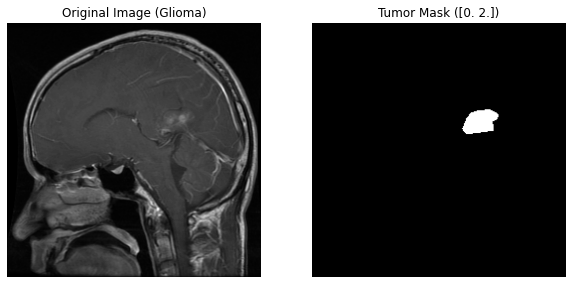

In [7]:
randInt = np.random.randint(0,len(df))

# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 1
columns = 2

img  = df.Images[randInt]
mask = df["Tumor Mask"][randInt]
tumorBorder = df["Tumor Border"][randInt]


# Display Original Image
fig.add_subplot(rows, columns, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image ({})'.format(df.Labels[randInt]))
plt.axis('off')
  
# Display Tumor Mask
fig.add_subplot(rows, columns, 2)
plt.imshow(mask, cmap='gray')
plt.title('Tumor Mask ({})'.format(np.unique(mask)))
plt.axis('off')
plt.show()

In [8]:
df.head()

,PID,Images,Tumor Mask,Tumor Border,Labels,File name
0,100360,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[267.6152450090744, 231.37568058076226, 277.83...",Meningioma,1.mat
1,101016,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[248.86411149825784, 256.89198606271776, 238.1...",Meningioma,10.mat
2,107494,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[193.26370732550265, 175.8076305348121, 185.15...",Meningioma,100.mat
3,112649,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[225.95188511210213, 231.1718956592464, 233.40...",Pituitary,1000.mat
4,112649,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[231.61100841767436, 237.4012836281162, 241.02...",Pituitary,1001.mat


In [9]:
## Splitting Images form masks
img_size = 256

Y = df["Tumor Mask"].tolist()
X = df['Images'].tolist()

## Adding extra Color channel to the grayscale images
Y = np.array(Y).reshape(-1, img_size, img_size)
Y = Y.astype(float)

X = np.array(X).reshape(-1, img_size, img_size)

print(f"shape of images: {X.shape}\nshape of labels: {Y.shape}")

shape of images: (3064, 256, 256)
shape of labels: (3064, 256, 256)


In [10]:
from sklearn.preprocessing import LabelEncoder

train_masks = Y
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped.ravel())
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

array([0, 1, 2, 3], dtype=int64)

In [11]:
from tensorflow.keras.utils import normalize

train_images = np.expand_dims(X, axis=3)
train_images = train_images/255

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
n_classes = len(np.unique(train_masks_input))

X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size=0.25, random_state=42)
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 


train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

Class values in the dataset are ...  [0 1 2 3]


In [13]:
print("X_train shape:", X_train.shape,"| y_train shape:", y_train_cat.shape)
print("X_test shape :",X_test.shape,"| y_test shape : ", y_test_cat.shape)

print("\nTotal Data: ", len(df))

X_train shape: (2298, 256, 256, 1) | y_train shape: (2298, 256, 256, 4)
X_test shape : (766, 256, 256, 1) | y_test shape :  (766, 256, 256, 4)

Total Data:  3064


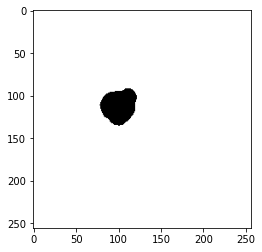

In [14]:
plt.imshow(y_test_cat[0, :, :, 0], 'gray')

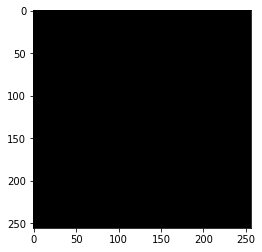

In [15]:
plt.imshow(y_test_cat[0, :, :, 1], 'gray')

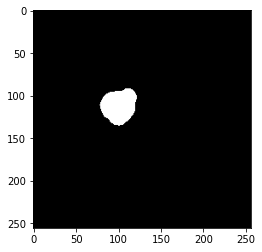

In [16]:
plt.imshow(y_test_cat[0, :, :, 2], 'gray')

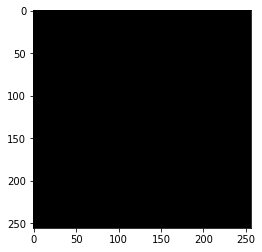

In [17]:
plt.imshow(y_test_cat[0, :, :, 3], 'gray')

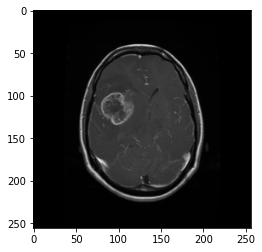

In [18]:
plt.imshow(X_test[0, :, :, :], 'gray')

In [19]:
X_test[0, :, :, :].max()

1.0

In [20]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(train_masks_reshaped_encoded),
                                                 y = train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

Class weights are...: [ 0.25429786 60.93108919 24.36493005 98.53238675]


In [21]:
# class_weights = {0: class_weights[0], 1: class_weights[1], 2: class_weights[2], 3: class_weights[3]}
# print("Class weights are...:", class_weights)

In [22]:
# Building Unet by dividing encoder and decoder into blocks
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(n_classes, input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    return model


In [23]:
# import os
# exp_num = []
# if not os.path.exists("./experiments"):
#     os.mkdir("./experiments")
# folders = os.listdir("./experiments")
# for folder in folders:
#     exp_num.append(int(folder.split("#")[1]))


# if len(exp_num) == 0:
#     exp_path = r"./experiments/exp#1"
# else:
#     exp_path = r"./experiments/exp#"+str(max(exp_num)+1)




# os.mkdir(exp_path)
# os.mkdir(os.path.join(exp_path, "results"))
# os.mkdir(os.path.join(exp_path, "weights"))

# results = os.path.join(exp_path, "results")
# weights = os.path.join(exp_path, "weights")

In [24]:
# input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

# model = build_unet(n_classes, input_shape)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [25]:
# from keras.callbacks import ModelCheckpoint

# model_checkpoint_callback = ModelCheckpoint(
#     filepath= os.path.join(weights, "best.h5"),
#     verbose=1, 
#     save_best_only=False, 
#     mode='max')
    
# model.fit(X_train, 
#         y_train_cat, 
#         batch_size = 4, 
#         verbose=1, 
#         epochs=60, 
#         validation_data=(X_test, y_test_cat), 
#         callbacks=[model_checkpoint_callback],
# #         sample_weight=np.array(class_weights),
#         shuffle=False)

In [26]:
# acc = model.evaluate(X_test, y_test_cat)[0]
# name = str(round(acc, 4))

In [27]:
# Save The Trained model along with it training history   
# metrics.to_pickle(os.path.join(results, name+'.pkl'))
# model.save(os.path.join(weights, "First_Mulit_UNet" + '.h5'))

In [28]:
model = tf.keras.models.load_model(r".\experiments\exp#16\weights\best.h5")
metrics = pd.read_pickle(r".\experiments\exp#16\results\metrics.pkl""")

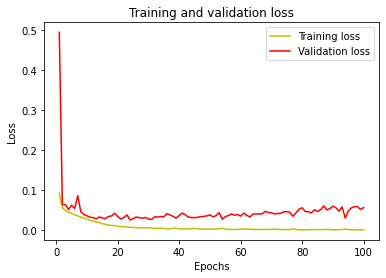

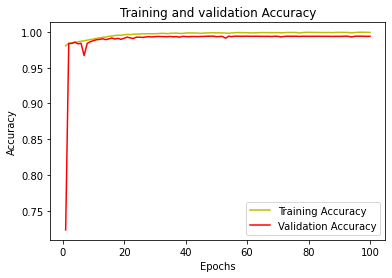

In [29]:
loss = metrics['loss']
val_loss = metrics['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

accuracy = metrics['accuracy']
val_accuracy = metrics['val_accuracy']

plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

ResourceExhaustedError:  OOM when allocating tensor with shape[32,512,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node U-Net/concatenate_1/concat (defined at \AppData\Local\Temp/ipykernel_28724/2438622344.py:2) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_3313]

Function call stack:
predict_function


In [ ]:
def prob_class(predicted_img, class_dic):
    rev_classes_dict = dict([(value, key) for key, value in class_dic.items()])
    result = ""
    if len(np.unique(predicted_img)) == 1:
        result = "(No Tumor)"
    else:
        for cls in np.unique(predicted_img):
            if cls != 0:
                prob = (predicted_img == cls).sum() / (0 != predicted_img).sum() 
                result += "({} {}%) ".format(rev_classes_dict[cls], str( round(prob*100, 2) ))

    return result

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
rev_classes_dict = dict([(value, key) for key, value in classes_dict.items()])



test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label\n({})'.format(rev_classes_dict[np.unique(ground_truth)[1]]))
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image\n{}'.format(prob_class(predicted_img, classes_dict)))
plt.imshow(predicted_img, cmap='jet')
plt.show()